# Oral Cancer Classification

In [2]:
import os
import shutil
import pathlib
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, regularizers

from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

## Train Test Split

In [32]:
# Stratified train test split

original_dir = pathlib.Path("Content_3class_new")
new_base_dir = pathlib.Path("oral_cancer_train_test_split")

def make_subset(subset_name, category_files):
    for category, files in category_files.items():
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        for fname in files:
            src = original_dir / category / fname
            if src.exists():
                shutil.copy(src, dir / fname)

def get_file_names(category):
    category_dir = original_dir / category
    return [f.name for f in category_dir.glob('*') if f.suffix in ['.jpg', '.jpeg', '.png']]

# classes
categories = ["normal", "pre_cancer", "oral_cancer"]

train_files = {}
test_files = {}

# stratified splitting
for category in categories:
    all_files = get_file_names(category)

    train, test = train_test_split(all_files, test_size=0.2, random_state=42, stratify=[category]*len(all_files))

    train_files[category] = train
    test_files[category] = test

make_subset("train", train_files)
make_subset("test", test_files)

print('Created stratified training and testing subsets')

Created stratified training and testing subsets


## CNN Model

In [4]:
# model
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)  # reduce overfitting
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # regularization
outputs = layers.Dense(3, activation="softmax")(x)  # softmax for multi-class

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

2024-09-18 11:00:24.786889: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,523 (19.48 MB)

 Trainable params: 5,107,523 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## Load Data

In [14]:
# read dataset
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(224, 224), batch_size=32)

for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Found 685 files belonging to 3 classes.
Found 173 files belonging to 3 classes.
Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


## Train CNN

In [6]:
# fit model
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="cnn.keras", save_best_only=True, monitor="val_loss") ]

history = model.fit( train_dataset, epochs=10, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/10


2024-09-18 11:00:33.100397: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:34.460565: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.2500 - loss: 1.1055

2024-09-18 11:00:34.829210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:36.180299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.



 2/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2656 - loss: 1.2350 

2024-09-18 11:00:36.526573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3321 - loss: 1.1781 - val_accuracy: 0.3179 - val_loss: 1.0954
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3566 - loss: 1.0935 - val_accuracy: 0.3526 - val_loss: 1.0578
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3244 - loss: 1.0861 - val_accuracy: 0.4451 - val_loss: 1.1005
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4513 - loss: 1.0434 - val_accuracy: 0.3295 - val_loss: 1.1433
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4438 - loss: 1.0472 - val_accuracy: 0.3410 - val_loss: 1.1250
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4422 - loss: 1.0223 - val_accuracy: 0.4277 - val_loss: 1.1851
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5650 - loss: 0.8805 - val_accuracy: 0.4566 - val_loss: 1.0392
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5625 - loss: 0.8722 - val_accuracy: 0.5145 - val_loss: 0.9942
Epo

In [9]:
history2 = model.fit( train_dataset, epochs=5, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6125 - loss: 0.7162 - val_accuracy: 0.5549 - val_loss: 0.9023
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7013 - loss: 0.6506 - val_accuracy: 0.5376 - val_loss: 0.9077
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6551 - loss: 0.6704 - val_accuracy: 0.5087 - val_loss: 0.9290
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6805 - loss: 0.6089 - val_accuracy: 0.5260 - val_loss: 0.9459
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6912 - loss: 0.5744 - val_accuracy: 0.5202 - val_loss: 0.8856


In [3]:
def plot_training_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(accuracy) + 1)

    # accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

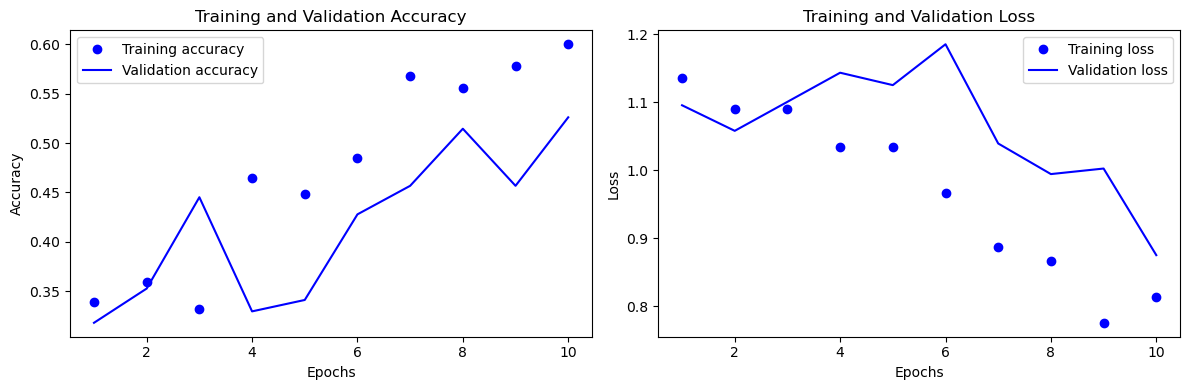

In [8]:
plot_training_history(history)

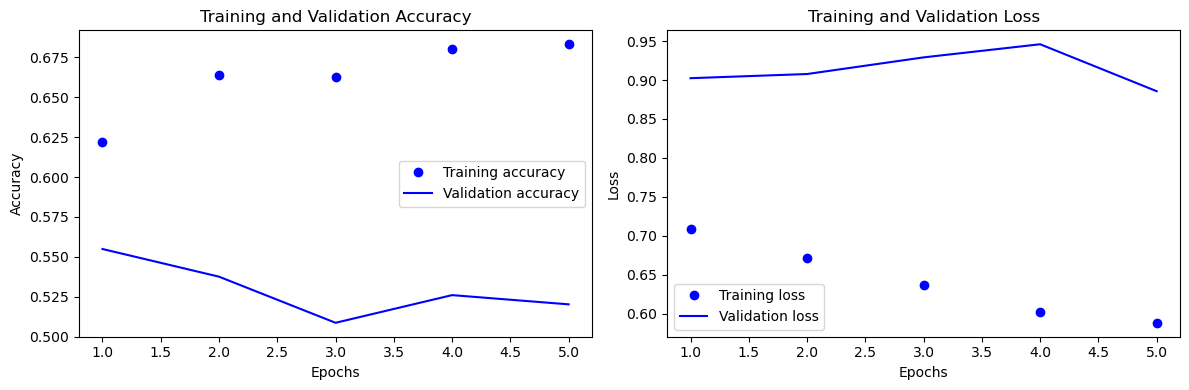

In [10]:
plot_training_history(history2)

In [42]:
test_model = keras.models.load_model("cnn.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.5330 - loss: 0.9065
Test accuracy: 0.526


## Data Augmentation

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,   # normalization
    shear_range=15,   # shearing [-15°, 15°]
    width_shift_range=0.15,  # translation [-15, 15]
    height_shift_range=0.15,
    rotation_range=25,  # rotation [-25°, 25°]
    zoom_range=0.2,     # zoom augmentation
    horizontal_flip=True,  # flip augmentation
)

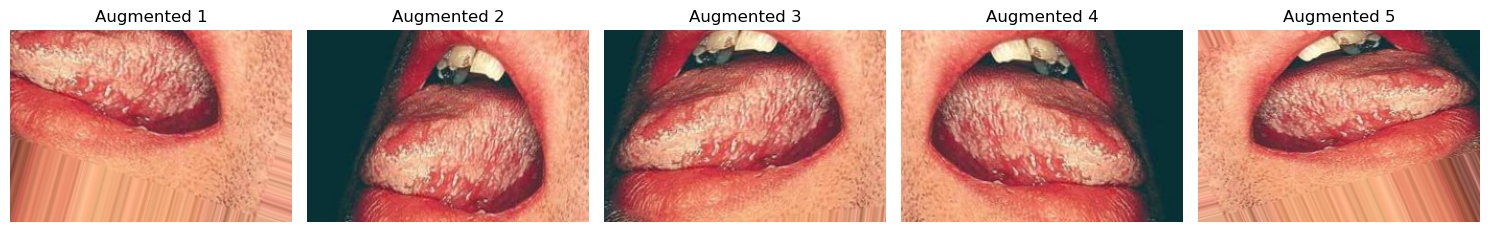

In [15]:
image_path = './oral_cancer_train_test_split/train/oral_cancer/oral_cancer.73.jpg'
image = load_img(image_path)  
image = img_to_array(image)   
image = np.expand_dims(image, axis=0)  

aug_iter = train_datagen.flow(image, batch_size=1)

fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    batch = next(aug_iter)
    ax = axes[i]
    img = batch[0]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
        'oral_cancer_train_test_split/train/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_data = test_datagen.flow_from_directory(
        'oral_cancer_train_test_split/test/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 685 images belonging to 3 classes.
Found 173 images belonging to 3 classes.


## Evaluation Functions

### Prediction

In [4]:
from keras.utils import load_img, img_to_array

def load_and_preprocess_image(img_path):
        """Load and preprocess a single image."""
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return np.expand_dims(img_array, axis=0)

def display_model_predictions(model, root_dir='./oral_cancer_train_test_split/test',
                                    class_names=['normal', 'oral_cancer', 'pre_cancer'],
                                    num_images=5, display_image=False):
    '''Custom function to display model predictions'''

    def load_images_from_class(class_dir, class_label, num_images):
        """Load a specified number of images from a given class directory."""
        images = []
        img_files = random.sample(os.listdir(class_dir), num_images)
        for img_file in img_files:
            img_path = os.path.join(class_dir, img_file)
            img_array = load_and_preprocess_image(img_path)
            images.append((img_path, img_array, class_label))
        return images

    def load_images_from_all_classes(root_dir, class_names, num_images):
        """Load images from all specified classes in the root directory."""
        all_images = []
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            all_images.extend(load_images_from_class(class_dir, class_name, num_images))
        return all_images

    def predict_images(model, images, class_map):
        """Make predictions on a list of images using the provided model."""
        predictions = []
        for img_path, img_array, true_class in images:
            pred = model.predict(img_array)
            pred_class_idx = np.argmax(pred, axis=1)[0]
            predictions.append((img_path, true_class, class_map[pred_class_idx], np.max(pred, axis=1)[0]))
        return predictions

    def display_images_with_predictions(images, predictions, class_map):
        """Display images with their true and predicted classes."""
        plt.figure(figsize=(15, 10))
        num_images = len(predictions)
        cols = 5
        rows = (num_images // cols) + (num_images % cols > 0)
        for i, (img_path, true_class, pred_class, _) in enumerate(predictions):
            img = image.load_img(img_path, target_size=(224, 224))  
            plt.subplot(3, 5, i + 1) 
            plt.imshow(img)
            plt.title(f'True: {true_class}\nPred: {pred_class}') 
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    all_images = load_images_from_all_classes(root_dir, class_names, num_images)
    
    class_map = {0: 'normal', 1: 'oral_cancer', 2: 'pre_cancer'}

    predictions = predict_images(model, all_images, class_map)

    for img_path, true_class, pred_class, confidence in predictions:
        print(f"Image: {os.path.basename(img_path)} - True Class: {true_class}, Predicted Class: {pred_class}")
    
    if display_image:
        display_images_with_predictions(all_images, predictions, class_map)

## CNN with Data Augmentation

In [11]:
# custom CNN model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model():
    model = keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

custom_cnn_model = create_model()
custom_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,258,755 (31.50 MB)

 Trainable params: 8,256,771 (31.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="custom_cnn.keras", save_best_only=True, monitor="val_loss") ]

history = custom_cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5945 - loss: 0.7716 - val_accuracy: 0.3121 - val_loss: 6.1619
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6118 - loss: 0.7963 - val_accuracy: 0.3121 - val_loss: 7.1792
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6240 - loss: 0.7956 - val_accuracy: 0.3295 - val_loss: 6.1772
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5700 - loss: 0.7408 - val_accuracy: 0.3468 - val_loss: 5.5907
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6064 - loss: 0.7589 - val_accuracy: 0.3642 - val_loss: 3.4290
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6202 - loss: 0.7269 - val_accuracy: 0.3988 - val_loss: 2.9322
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6325 - loss: 0.7457 - val_accuracy: 0.3931 - val_loss: 3.3590
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5857 - loss: 0.7653 - val_accuracy: 0.4335 - val_loss:

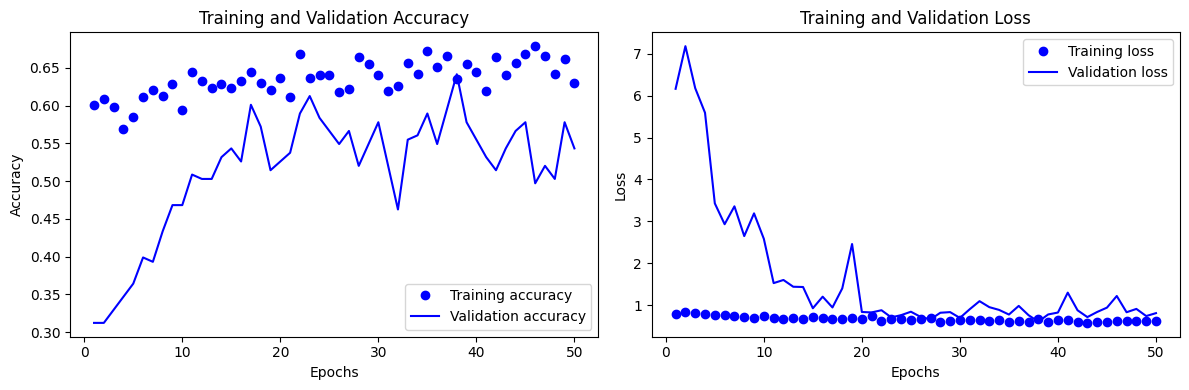

In [17]:
plot_training_history(history)

In [18]:
display_model_predictions(custom_cnn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image: normal.248.jpeg - True Class: normal, Predicted Class: normal
Image: normal.229.jpeg - True Class: normal, Predicted Class: oral_cancer
Image: normal.257.jpeg - True Class: normal, Predicted Class: normal
Image: normal.259.jpeg - True Class: normal, Predicted Class: normal
Image: normal.255.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.262.jpg - True Class: oral_cancer, Predicted Class:

## Pre-trained Models

### ResNet101

In [7]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.summary()

In [29]:
# train resnet
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="resnet.keras", save_best_only=True, monitor="val_loss") ]

history = resnet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

In [ ]:
history = np.load('resnet_history.npy',allow_pickle='TRUE').item()

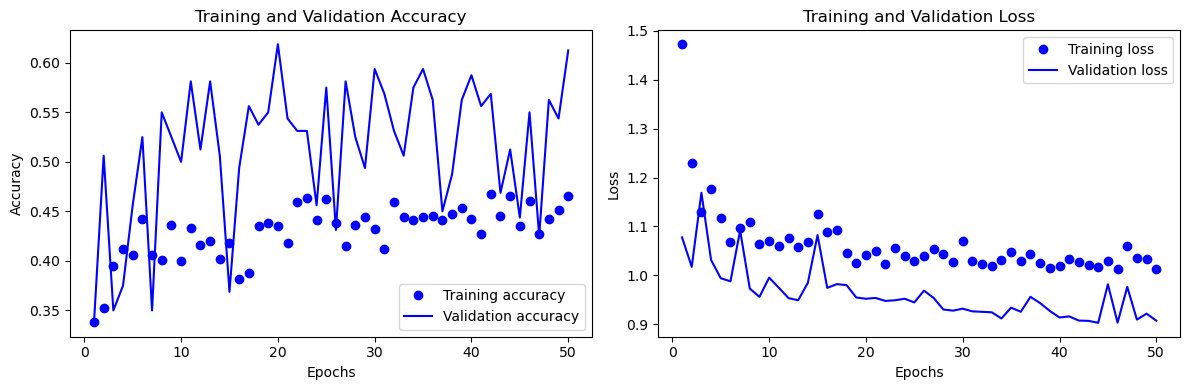

In [38]:
plot_training_history(history)

In [41]:
resnet_model = keras.models.load_model("resnet.keras")
test_loss, test_acc = resnet_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 30s 4s/step - loss: 0.9057 - accuracy: 0.5029
Test accuracy: 0.503


In [56]:
display_model_predictions(resnet_model)

1/1 [==============================] - 0s 180ms/step
Image: normal.255.jpeg - True Class: normal, Predicted Class: normal
Image: normal.218.jpeg - True Class: normal, Predicted Class: normal
Image: normal.230.jpeg - True Class: normal, Predicted Class: normal
Image: normal.242.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.241.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.263.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.248.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.233.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.300.jpg - True Class: pre_cancer, Predicted Class: normal
Image: pre_cancer.303.jpeg - True Class: pre_cancer, Predicted Class: normal
Image: pre_cancer.289.png - True Class: pre_cancer

### VGG16

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=predictions)

vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 528,387 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
# train vgg16
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

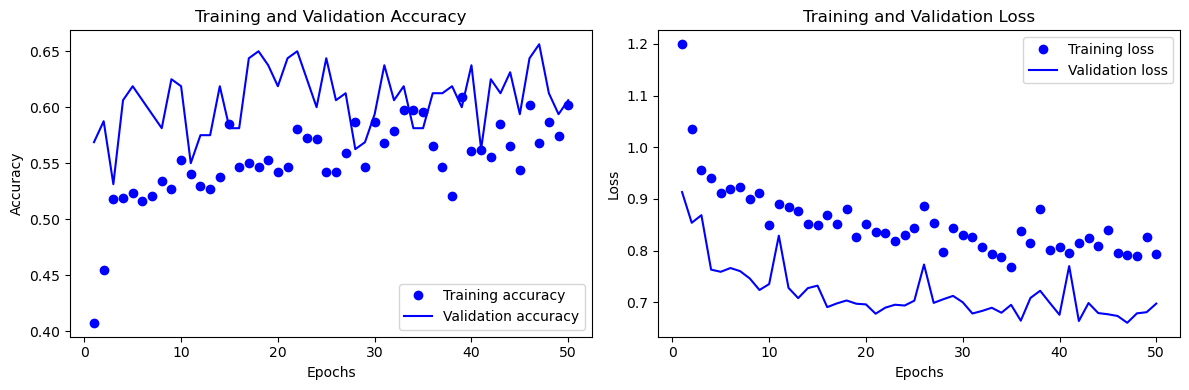

In [35]:
plot_training_history(history)

In [53]:
vgg16_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = vgg16_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 49s 8s/step - loss: 0.6682 - accuracy: 0.6474
Test accuracy: 0.647


In [58]:
display_model_predictions(vgg16_model)

1/1 [==============================] - 0s 281ms/step
Image: normal.252.jpeg - True Class: normal, Predicted Class: normal
Image: normal.240.jpeg - True Class: normal, Predicted Class: normal
Image: normal.254.jpeg - True Class: normal, Predicted Class: normal
Image: normal.262.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.275.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.268.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.280.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.232.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.278.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.278.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.250.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.293.jpg - Tru

In [60]:
# unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [29]:
# fine-tuning
vgg16_model = keras.models.load_model("vgg16.keras")
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16_finetuned.keras", 
                                              save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

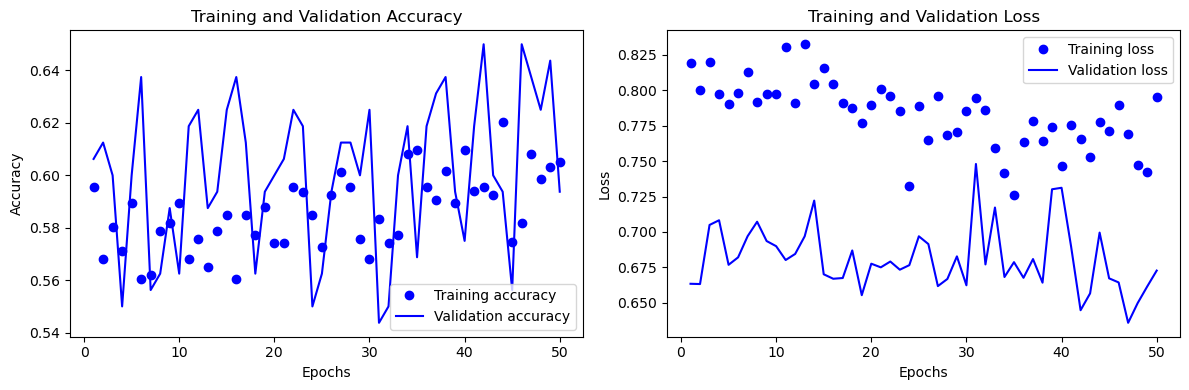

In [51]:
plot_training_history(history)

In [61]:
vgg16_finetuned_model = keras.models.load_model("vgg16_finetuned.keras")

In [65]:
display_model_predictions(vgg16_finetuned_model)

1/1 [==============================] - 0s 339ms/step
Image: normal.264.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: normal.244.jpeg - True Class: normal, Predicted Class: normal
Image: normal.258.jpeg - True Class: normal, Predicted Class: normal
Image: normal.229.jpeg - True Class: normal, Predicted Class: normal
Image: normal.215.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.243.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.279.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.234.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.240.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.282.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.279.jpg - True Class: pre_cancer, Predicted Class: oral_cancer
Image: pre_cancer.269.jpg - Tr

### VGG19

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg19_model = Model(inputs=base_model.input, outputs=predictions)

vgg19_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# vgg19_model.summary()

In [ ]:
# train vgg19
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg19.keras", save_best_only=True, monitor="val_loss") ]

history = vgg19_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

In [86]:
vgg19_model = keras.models.load_model("vgg19.keras")

### InceptionV3

In [12]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# inceptionv3_model.summary()

In [ ]:
# train inceptionv3
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

In [ ]:
# fine-tuning
# freeze the first 249 layers and unfreeze the rest
for layer in base_model.layers[:310]:
    layer.trainable = False
for layer in base_model.layers[310:]:
    layer.trainable = True
    
inceptionv3_model = keras.models.load_model("inceptionv3.keras")
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

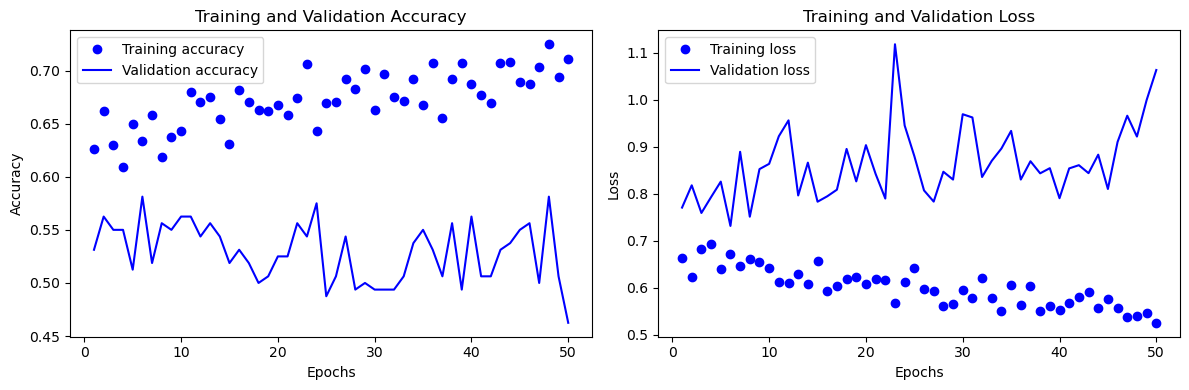

In [67]:
plot_training_history(history)

In [68]:
inceptionv3_model = keras.models.load_model("inceptionv3.keras")

In [71]:
display_model_predictions(inceptionv3_model)

1/1 [==============================] - 0s 73ms/step
Image: normal.258.jpeg - True Class: normal, Predicted Class: normal
Image: normal.225.jpeg - True Class: normal, Predicted Class: normal
Image: normal.263.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: normal.229.jpeg - True Class: normal, Predicted Class: normal
Image: normal.247.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.236.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.275.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.270.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.232.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.297.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.258.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.262.jp

### DenseNet121

In [10]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(3, activation='softmax')(x)

densenet_model = Model(inputs=base_model.input, outputs=predictions)

densenet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="densenet.keras", save_best_only=True, monitor="val_loss") ]

history = densenet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

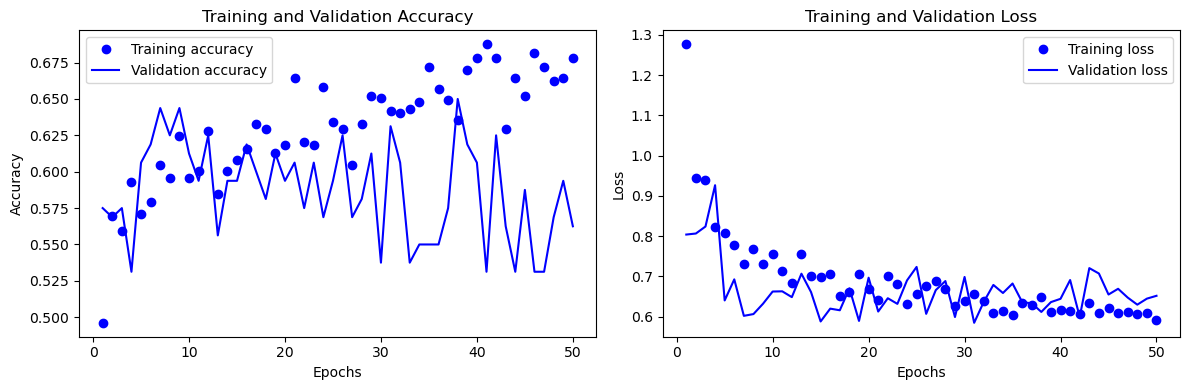

In [74]:
plot_training_history(history)

In [75]:
densenet_model = keras.models.load_model("densenet.keras")

In [78]:
display_model_predictions(densenet_model)

1/1 [==============================] - 0s 96ms/step
Image: normal.246.jpeg - True Class: normal, Predicted Class: normal
Image: normal.257.jpeg - True Class: normal, Predicted Class: normal
Image: normal.221.jpeg - True Class: normal, Predicted Class: normal
Image: normal.214.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.231.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.241.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.232.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.248.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.265.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.297.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.273.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.286.jpg - True 

In [ ]:
# finetune
# freeze first 141 layers and unfreeze the rest
for layer in base_model.layers[:141]:
    layer.trainable = False
for layer in base_model.layers[141:]:
    layer.trainable = True
    
densenet_model = keras.models.load_model("densenet.keras")
    
densenet_model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="densenet_finetuned.keras", save_best_only=True, monitor="val_loss") ]

history_finetuned = densenet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size
)

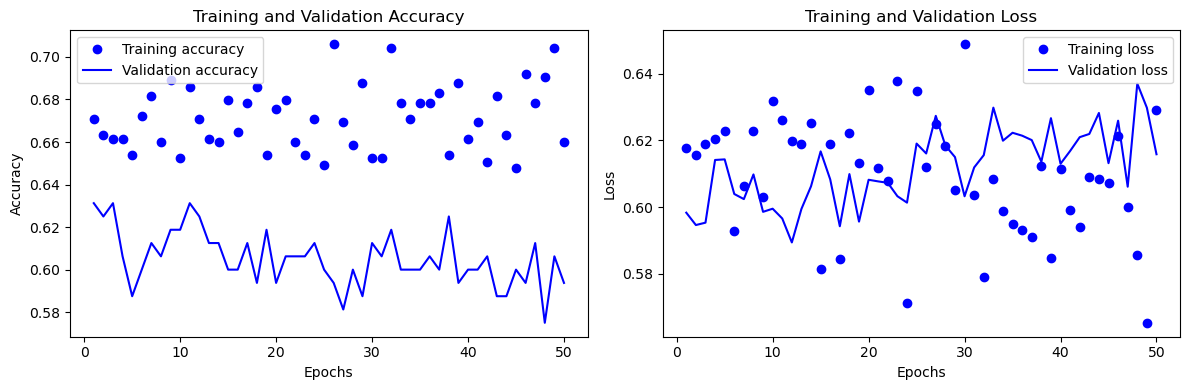

In [80]:
plot_training_history(history)

In [81]:
densenet_finetuned_model = keras.models.load_model("densenet.keras")

In [84]:
display_model_predictions(densenet_finetuned_model)

1/1 [==============================] - 0s 94ms/step
Image: normal.228.jpeg - True Class: normal, Predicted Class: normal
Image: normal.215.jpeg - True Class: normal, Predicted Class: normal
Image: normal.238.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: normal.252.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.275.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.227.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.252.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.268.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.230.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.287.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.277.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.276.jpg - T

## Viewing image predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: normal.222.jpeg - True Class: normal, Predicted Class: oral_cancer
Image: normal.236.jpeg - True Class: normal, Predicted Class: normal
Image: normal.240.jpeg - True Class: normal, Predicted Class: normal
Image: normal.246.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.226.jpg - True Class: oral_cancer, Predicted Class: oral_canc

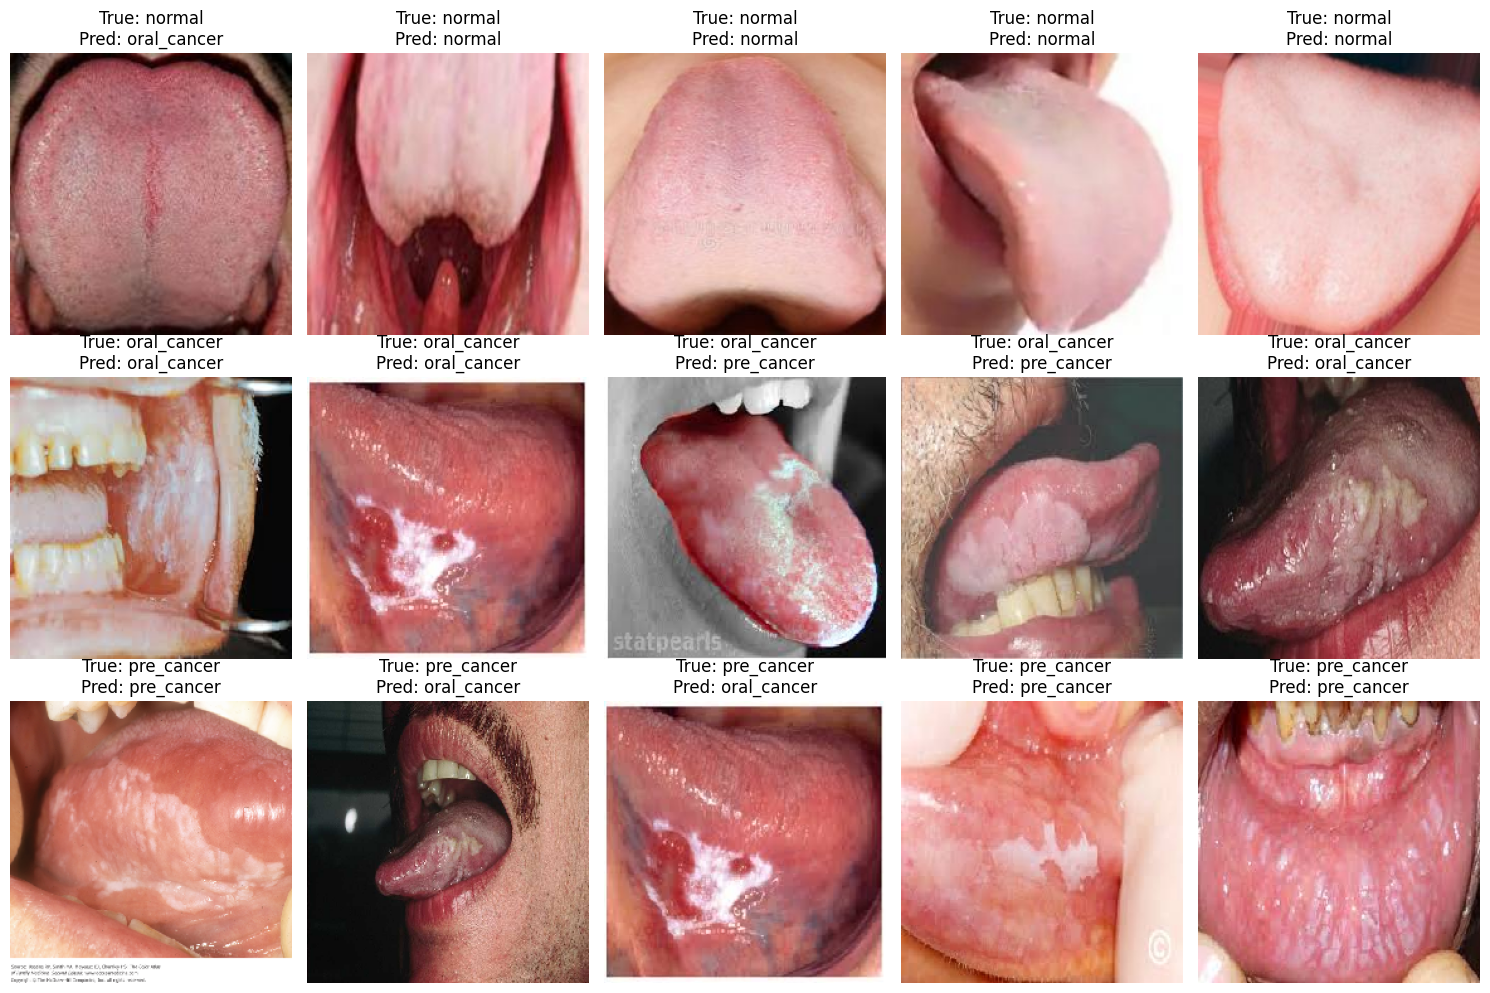

In [38]:
model = keras.models.load_model('custom_cnn.keras')
display_model_predictions(model, display_image=True)

## Checking Duplicates

In [33]:
# Turns out there are duplicate images across different classes
# Poor performance of the model could be attributed to this
# Checking for duplicates across classes

from PIL import Image
import imagehash
import os

def find_duplicates(folders):
    hashes = {}
    duplicates = []

    for folder in folders:
        image_files = []
        for dirpath, _, filenames in os.walk(folder):
            for filename in filenames:
                if filename.lower().endswith(('jpg', 'jpeg', 'png')):
                    image_files.append(os.path.join(dirpath, filename))
        
        for file_path in image_files:
            img_hash = imagehash.average_hash(Image.open(file_path))

            # check duplicates based on hash
            if img_hash in hashes:
                duplicates.append((file_path, hashes[img_hash]))
            else:
                hashes[img_hash] = file_path

    return duplicates

folders_to_check = [
    'Content_3class_new/normal',
    'Content_3class_new/oral_cancer',
    'Content_3class_new/pre_cancer'
]

duplicates = find_duplicates(folders_to_check)

def filter_different_folder_duplicates(duplicates):
    different_folder_duplicates = []
    for file1, file2 in duplicates:
        folder1 = file1.split('/')[0:-1]
        folder2 = file2.split('/')[0:-1]
        
        if folder1 != folder2:
            different_folder_duplicates.append((file1, file2))
    
    return different_folder_duplicates, folder1[1], folder2[1]

filtered_duplicates, class1, class2 = filter_different_folder_duplicates(duplicates)

dupes = len(filtered_duplicates)

print()
print("\033[1;31m" + f'Found {dupes} duplicate images between classes "{class1}" and "{class2}"!' + "\033[0m")
print('\nDuplicate images: \n')
for dup in filtered_duplicates:
    print(dup)


Found 234 duplicate images between classes "pre_cancer" and "oral_cancer"!

Duplicate images: 

('Content_3class_new/pre_cancer/pre_cancer.274.jpg', 'Content_3class_new/oral_cancer/oral_cancer.237.jpg')
('Content_3class_new/pre_cancer/pre_cancer.133.jpg', 'Content_3class_new/oral_cancer/oral_cancer.152.jpg')
('Content_3class_new/pre_cancer/pre_cancer.44.jpg', 'Content_3class_new/oral_cancer/oral_cancer.71.jpg')
('Content_3class_new/pre_cancer/pre_cancer.90.jpg', 'Content_3class_new/oral_cancer/oral_cancer.243.jpg')
('Content_3class_new/pre_cancer/pre_cancer.46.jpg', 'Content_3class_new/oral_cancer/oral_cancer.73.jpg')
('Content_3class_new/pre_cancer/pre_cancer.256.png', 'Content_3class_new/oral_cancer/oral_cancer.98.png')
('Content_3class_new/pre_cancer/pre_cancer.191.jpg', 'Content_3class_new/oral_cancer/oral_cancer.201.jpg')
('Content_3class_new/pre_cancer/pre_cancer.145.jpeg', 'Content_3class_new/oral_cancer/oral_cancer.150.jpg')
('Content_3class_new/pre_cancer/pre_cancer.1.jpeg', 

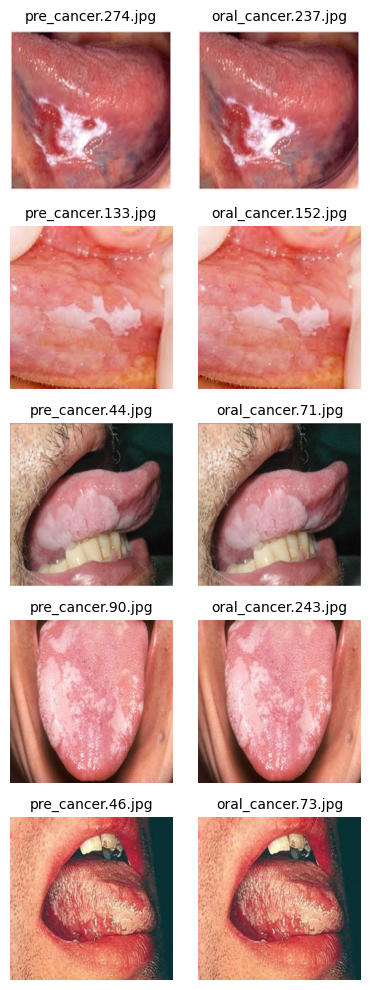

In [30]:
# display duplicates
image_pairs = filtered_duplicates[:5]

num_rows = len(image_pairs)
fig, axes = plt.subplots(num_rows, 2, figsize=(4, num_rows * 2))

for i, (img1_path, img2_path) in enumerate(image_pairs):
    try:
        img1 = Image.open(img1_path).resize((224, 224))
        img2 = Image.open(img2_path).resize((224, 224))

        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        
        axes[i, 0].set_title(os.path.basename(img1_path), fontsize=10, loc='center')
        axes[i, 1].set_title(os.path.basename(img2_path), fontsize=10, loc='center')
        
    except Exception as e:
        print(f"Error loading images: {e} for paths {img1_path} and {img2_path}")

plt.tight_layout()
plt.show()

## Move duplicates for annotation

In [6]:
# we delete the duplicate images from the dataset
# and move the duplicate images to another folder for accurate annotation (by medical experts)

duplicate_dir = 'Content_3class_new/duplicate_images'
os.makedirs(duplicate_dir, exist_ok=True)

for index, (pre_cancer_img, oral_cancer_img) in enumerate(filtered_duplicates, start=1):
    if os.path.exists(oral_cancer_img):
        os.remove(oral_cancer_img)
    
    if os.path.exists(pre_cancer_img):
        new_filename = f'img.{index}.jpg'
        new_filepath = os.path.join(duplicate_dir, new_filename)
        
        shutil.move(pre_cancer_img, new_filepath)
        
print(f'Moved duplicate images to {duplicate_dir}.')

Moved duplicate images to Content_3class_new/duplicate_images.


## Data Augmentation for data generation

In [15]:
from tqdm import tqdm
from PIL import Image

# since our dataset became even smaller we use data augmentation to generate image samples
datagen = ImageDataGenerator(
    rotation_range=25,  # rotation [-25°, 25°]
    width_shift_range=0.15,  # translation [-15, 15]
    height_shift_range=0.15,
    shear_range=15,   # shearing [-15°, 15°]
    zoom_range=0.2,     # zoom augmentation
    horizontal_flip=True,  # flip augmentation
    fill_mode='nearest'
)

normal_dir = 'Content_3class_new/normal'
oral_cancer_dir = 'Content_3class_new/oral_cancer'
pre_cancer_dir = 'Content_3class_new/pre_cancer'

augmented_normal_dir = 'Content_3class_new/augmented_normal'
augmented_oral_cancer_dir = 'Content_3class_new/augmented_oral_cancer'
augmented_pre_cancer_dir = 'Content_3class_new/augmented_pre_cancer'

# generate and save augmented images
def generate_augmented_images(datagen, input_dir, output_dir, num_images_to_generate):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image file names in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    # Total images available
    total_images = len(image_files)

    # Generate specified number of augmented images
    for i in tqdm(range(num_images_to_generate), desc='Generating..'):
        # Pick a random image from the folder
        img_name = image_files[np.random.randint(0, total_images)]
        img_path = os.path.join(input_dir, img_name)
        
        # Load the image
        img = load_img(img_path, target_size=(224, 224))  # Resize to the desired target size
        img_array = img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Generate an augmented image
        aug_iter = datagen.flow(img_array, batch_size=1)

        # Generate one augmented image and save it
        for batch in aug_iter:
            aug_img = batch[0].astype('uint8')  # Convert array back to image
            aug_img = Image.fromarray(aug_img)

            # Save the augmented image to the output directory
            aug_img.save(os.path.join(output_dir, f"aug_{i}.jpg"))
            break  # We only need one image per loop iteration


# generate images for each class
generate_augmented_images(datagen, normal_dir, augmented_normal_dir, 234)
generate_augmented_images(datagen, oral_cancer_dir, augmented_oral_cancer_dir, 361)
generate_augmented_images(datagen, pre_cancer_dir, augmented_pre_cancer_dir, 422)

print('Generated augmented images.')

Generating..: 100%|██████████████████████████| 422/422 [00:02<00:00, 155.29it/s]

Generated augmented images.


## Add augmented images

In [14]:
# we now create a new dataset combining the augmented images
# each class will now have 500 images

def move_and_rename_images(dataset_folder, augmented_folder, new_folder, class_name):
    os.makedirs(new_folder, exist_ok=True)

    counter = 1

    def process_folder(folder):
        nonlocal counter
        for filename in os.listdir(folder):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                new_filename = f'{class_name}.{counter}.jpg'
                
                src = os.path.join(folder, filename)
                dst = os.path.join(new_folder, new_filename)
                
                shutil.copy(src, dst)
                counter += 1

    process_folder(dataset_folder)
    process_folder(augmented_folder)

move_and_rename_images('Content_3class_new/normal', 'Content_3class_new/augmented_normal', 
                       'new_aug_dataset/normal', 'normal')
move_and_rename_images('Content_3class_new/oral_cancer', 'Content_3class_new/augmented_oral_cancer', 
                       'new_aug_dataset/oral_cancer', 'oral_cancer')
move_and_rename_images('Content_3class_new/pre_cancer', 'Content_3class_new/augmented_pre_cancer', 
                       'new_aug_dataset/pre_cancer', 'pre_cancer')
print('Created new dataset.')

Created new dataset.


### Train Test Split

In [20]:
# Stratified train test split

original_dir = pathlib.Path("new_aug_dataset")
if os.path.exists('oral_cancer_train_test_split'):
        shutil.rmtree('oral_cancer_train_test_split')
new_base_dir = pathlib.Path("oral_cancer_train_test_split")

def make_subset(subset_name, category_files):
    for category, files in category_files.items():
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        for fname in files:
            src = original_dir / category / fname
            if src.exists():
                shutil.copy(src, dir / fname)

def get_file_names(category):
    category_dir = original_dir / category
    return [f.name for f in category_dir.glob('*') if f.suffix in ['.jpg', '.jpeg', '.png']]

# classes
categories = ["normal", "pre_cancer", "oral_cancer"]

train_files = {}
test_files = {}

# stratified splitting
for category in categories:
    all_files = get_file_names(category)

    train, test = train_test_split(all_files, test_size=0.2, random_state=42, stratify=[category]*len(all_files))

    train_files[category] = train
    test_files[category] = test

make_subset("train", train_files)
make_subset("test", test_files)

print('Created stratified training and testing subsets.')

Created stratified training and testing subsets.


## Load data

In [10]:
# load datasets

batch_size = 16  # found to be best after hyperparamter tuning

# train
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'oral_cancer_train_test_split/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# test
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'oral_cancer_train_test_split/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=batch_size
)

class_names = test_dataset.class_names

test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


## Train Pretrained Models

In [7]:
# function to create and train using pretrained model

def create_and_train_model(train_dataset, test_dataset, model_name, input_shape=(224, 224, 3), 
                           num_classes=3, learning_rate=0.0005, l2_reg=0.005, dropout_rate=0.5, epochs=20):

    # load pretrained base model
    base_model_class = getattr(keras.applications, model_name)
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    # model architecture
    x = base_model.output
    x = layers.GlobalAveragePooling2D(data_format='channels_last', keepdims=False, 
                                      name='global_average_pooling2d')(x)

    # Dense Layer 1 (ReLU)
    x = layers.Dense(units=100, activation='relu', use_bias=True, 
                     kernel_initializer=initializers.VarianceScaling(scale=1, mode='fan_in', 
                     distribution='truncated_normal'), 
                     bias_initializer=initializers.Zeros(), 
                     kernel_regularizer=regularizers.l2(l2_reg), name='dense_layer1')(x)

    # Dropout Layer 
    x = layers.Dropout(rate=dropout_rate, name='dropout1')(x)

    # Dense Layer 2 (Softmax)
    predictions = layers.Dense(units=num_classes, activation='softmax', use_bias=False, 
                               kernel_initializer=initializers.VarianceScaling(scale=1, 
                               mode='fan_in', distribution='truncated_normal'), 
                               bias_initializer=initializers.Zeros(), 
                               kernel_regularizer=regularizers.l2(l2_reg), name='dense_layer2')(x)

    # create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

    # callbacks
    callbacks = [keras.callbacks.ModelCheckpoint(filepath=f"{model_name.lower()}.keras", save_best_only=True, 
                                                 monitor="val_loss")]

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        callbacks=callbacks
    )
    
    plot_training_history(history)

    return model

In [8]:
# function to evaluate trained model

def evaluate_and_display_model(model, test_dataset, class_names, display_image=True):
    
    loss, accuracy = model.evaluate(test_dataset)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    y_true = []
    y_pred = []

    # true labels and predictions
    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    display_model_predictions(model, display_image=display_image)

### ResNet101

Epoch 1/20
75/75 [==============================] - 15s 112ms/step - loss: 1.2933 - accuracy: 0.3750 - val_loss: 1.1195 - val_accuracy: 0.4067
Epoch 2/20
75/75 [==============================] - 5s 72ms/step - loss: 1.1168 - accuracy: 0.4142 - val_loss: 1.0689 - val_accuracy: 0.4833
Epoch 3/20
75/75 [==============================] - 4s 48ms/step - loss: 1.1062 - accuracy: 0.4067 - val_loss: 1.0870 - val_accuracy: 0.4400
Epoch 4/20
75/75 [==============================] - 5s 72ms/step - loss: 1.1008 - accuracy: 0.4117 - val_loss: 1.0667 - val_accuracy: 0.4900
Epoch 5/20
75/75 [==============================] - 6s 78ms/step - loss: 1.0835 - accuracy: 0.4308 - val_loss: 1.0548 - val_accuracy: 0.4533
Epoch 6/20
75/75 [==============================] - 6s 73ms/step - loss: 1.0768 - accuracy: 0.4325 - val_loss: 1.0429 - val_accuracy: 0.4533
Epoch 7/20
75/75 [==============================] - 5s 72ms/step - loss: 1.0635 - accuracy: 0.4300 - val_loss: 1.0285 - val_accuracy: 0.5233
Epoch 8/20


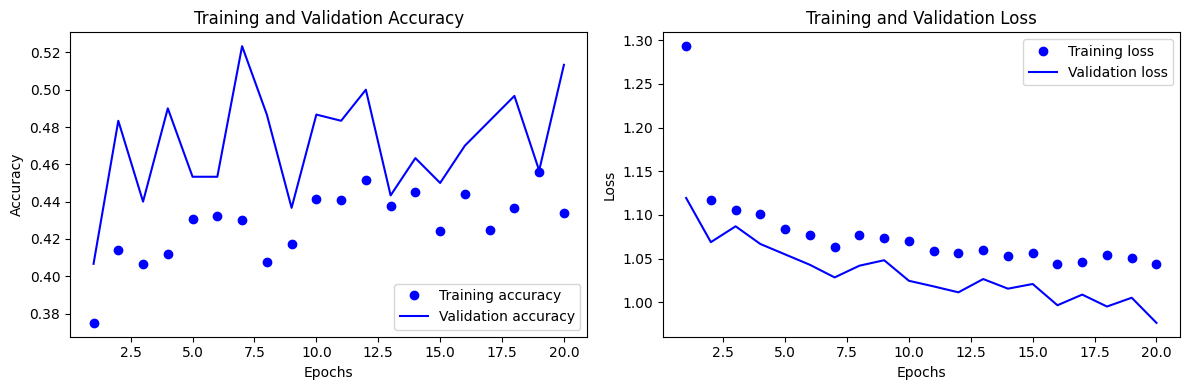

In [12]:
create_and_train_model(train_dataset, test_dataset, model_name='ResNet101', epochs=20)

19/19 [==============================] - 4s 36ms/step - loss: 0.9764 - accuracy: 0.5133
Test Loss: 0.9764284491539001
Test Accuracy: 0.5133333206176758
1/1 [==============================] - 0s 53ms/step


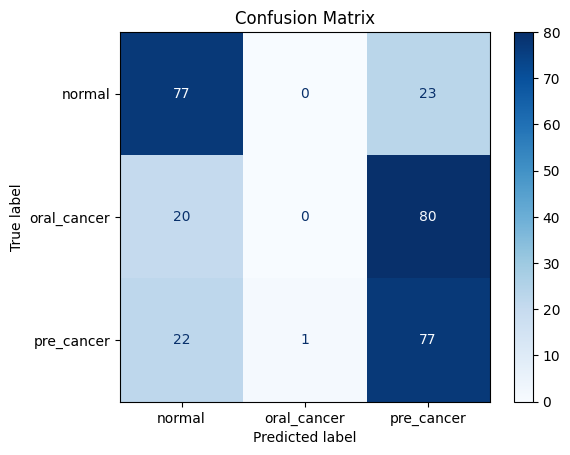

1/1 [==============================] - 0s 50ms/step
Image: normal.295.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: normal.61.jpg - True Class: normal, Predicted Class: normal
Image: normal.466.jpeg - True Class: normal, Predicted Class: normal
Image: normal.58.jpg - True Class: normal, Predicted Class: normal
Image: normal.77.jpg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.372.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.474.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.41.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.454.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.357.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.491.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.439.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.238.jpg - True Cla

In [14]:
model = tf.keras.models.load_model('resnet101.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### VGG16

Epoch 1/20
75/75 [==============================] - 10s 86ms/step - loss: 1.4435 - accuracy: 0.3742 - val_loss: 1.2396 - val_accuracy: 0.4867
Epoch 2/20
75/75 [==============================] - 4s 55ms/step - loss: 1.1887 - accuracy: 0.5033 - val_loss: 1.0829 - val_accuracy: 0.5733
Epoch 3/20
75/75 [==============================] - 3s 43ms/step - loss: 1.0863 - accuracy: 0.5383 - val_loss: 0.9988 - val_accuracy: 0.5833
Epoch 4/20
75/75 [==============================] - 3s 43ms/step - loss: 1.0358 - accuracy: 0.5658 - val_loss: 0.9587 - val_accuracy: 0.5800
Epoch 5/20
75/75 [==============================] - 3s 42ms/step - loss: 0.9981 - accuracy: 0.5683 - val_loss: 0.9252 - val_accuracy: 0.5867
Epoch 6/20
75/75 [==============================] - 3s 42ms/step - loss: 0.9540 - accuracy: 0.6092 - val_loss: 0.8911 - val_accuracy: 0.6200
Epoch 7/20
75/75 [==============================] - 3s 42ms/step - loss: 0.9467 - accuracy: 0.6000 - val_loss: 0.8796 - val_accuracy: 0.6333
Epoch 8/20
7

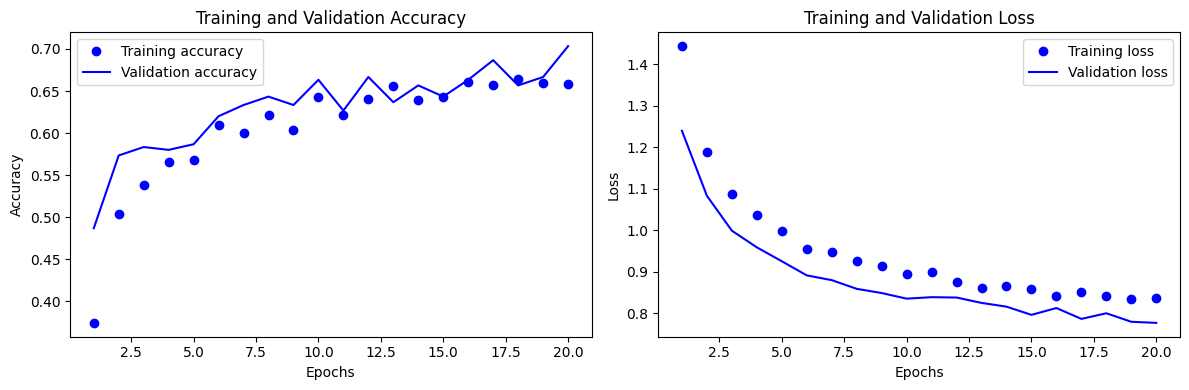

In [15]:
create_and_train_model(train_dataset, test_dataset, model_name='VGG16', epochs=20)

19/19 [==============================] - 1s 30ms/step - loss: 0.7766 - accuracy: 0.7033
Test Loss: 0.7766346335411072
Test Accuracy: 0.70333331823349
1/1 [==============================] - 0s 39ms/step


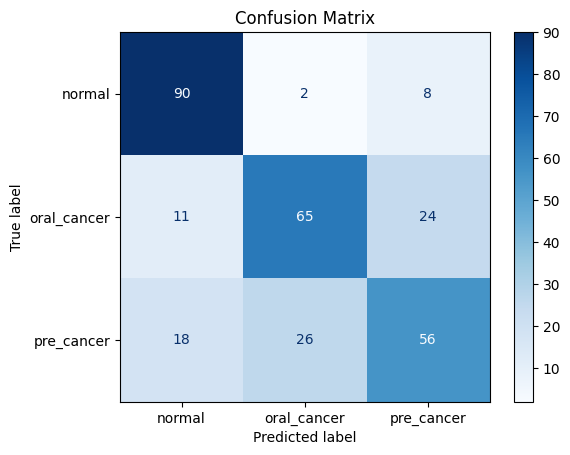

1/1 [==============================] - 0s 34ms/step
Image: normal.152.jpg - True Class: normal, Predicted Class: normal
Image: normal.352.jpeg - True Class: normal, Predicted Class: normal
Image: normal.358.jpeg - True Class: normal, Predicted Class: normal
Image: normal.103.jpg - True Class: normal, Predicted Class: normal
Image: normal.114.jpg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.44.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.438.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.421.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.169.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.394.jpeg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.190.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.33.jpg - True Class: pre_cancer, Predicted Class: oral_cancer
Image: pre_cancer.383.jpg -

In [16]:
model = tf.keras.models.load_model('vgg16.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### VGG19

Epoch 1/20


2024-10-07 07:44:05.034021: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-10-07 07:44:08.352976: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7b212ae2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-07 07:44:08.353032: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 3g.20gb, Compute Capability 8.0
2024-10-07 07:44:08.362751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728287048.489872  259701 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 12s 104ms/step - loss: 1.4629 - accuracy: 0.3525 - val_loss: 1.2577 - val_accuracy: 0.5200
Epoch 2/20
75/75 [==============================] - 5s 61ms/step - loss: 1.2043 - accuracy: 0.4658 - val_loss: 1.1032 - val_accuracy: 0.6067
Epoch 3/20
75/75 [==============================] - 4s 47ms/step - loss: 1.1141 - accuracy: 0.5108 - val_loss: 1.0353 - val_accuracy: 0.5800
Epoch 4/20
75/75 [==============================] - 4s 47ms/step - loss: 1.0729 - accuracy: 0.5142 - val_loss: 0.9809 - val_accuracy: 0.6400
Epoch 5/20
75/75 [==============================] - 4s 48ms/step - loss: 1.0307 - accuracy: 0.5575 - val_loss: 0.9513 - val_accuracy: 0.6033
Epoch 6/20
75/75 [==============================] - 4s 47ms/step - loss: 1.0170 - accuracy: 0.5458 - val_loss: 0.9323 - val_accuracy: 0.6267
Epoch 7/20
75/75 [==============================] - 4s 48ms/step - loss: 0.9889 - accuracy: 0.5550 - val_loss: 0.8996 - val_accuracy: 0.6833
Epoch 8/20
75/75 [====

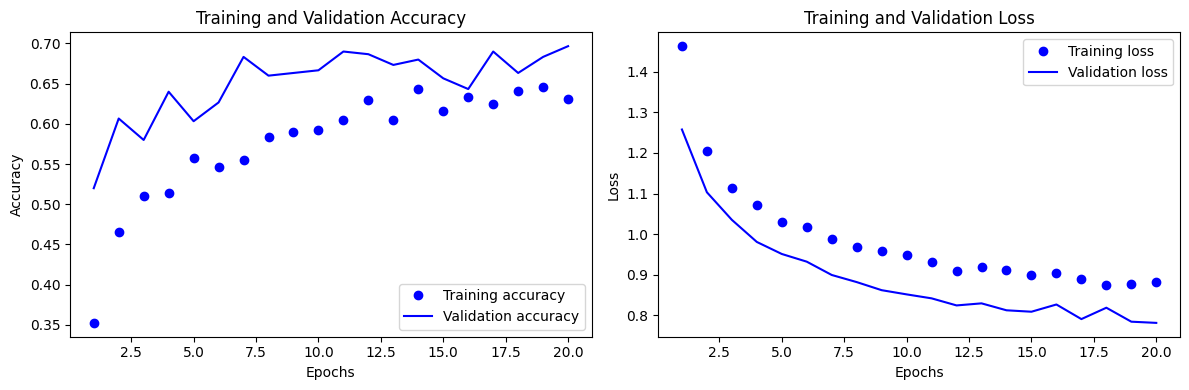

In [11]:
create_and_train_model(train_dataset, test_dataset, model_name='VGG19', epochs=20)

19/19 [==============================] - 1s 34ms/step - loss: 0.7816 - accuracy: 0.6967
Test Loss: 0.7816173434257507
Test Accuracy: 0.6966666579246521
1/1 [==============================] - 0s 42ms/step


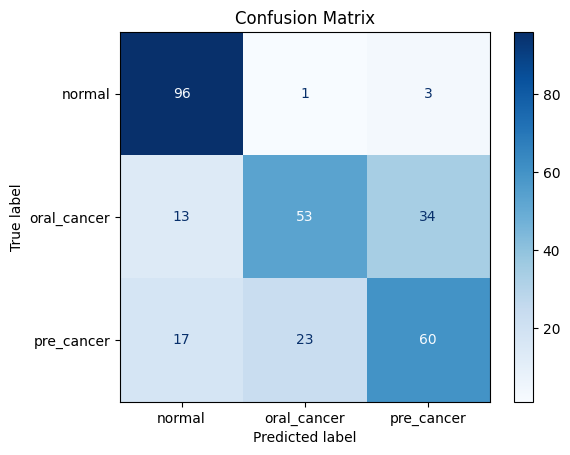

1/1 [==============================] - 0s 33ms/step
Image: normal.322.jpeg - True Class: normal, Predicted Class: normal
Image: normal.409.jpeg - True Class: normal, Predicted Class: normal
Image: normal.17.jpg - True Class: normal, Predicted Class: normal
Image: normal.473.jpeg - True Class: normal, Predicted Class: normal
Image: normal.101.jpg - True Class: normal, Predicted Class: normal
Image: oral_cancer.226.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.348.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.136.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.175.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.271.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.257.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.287.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.53.jpg - True C

In [12]:
model = tf.keras.models.load_model('vgg19.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### InceptionV3

Epoch 1/20
75/75 [==============================] - 15s 103ms/step - loss: 1.4493 - accuracy: 0.5283 - val_loss: 1.1867 - val_accuracy: 0.6967
Epoch 2/20
75/75 [==============================] - 4s 49ms/step - loss: 1.1423 - accuracy: 0.6567 - val_loss: 1.0058 - val_accuracy: 0.7400
Epoch 3/20
75/75 [==============================] - 2s 32ms/step - loss: 0.9913 - accuracy: 0.7125 - val_loss: 1.0138 - val_accuracy: 0.6467
Epoch 4/20
75/75 [==============================] - 4s 49ms/step - loss: 0.8774 - accuracy: 0.7517 - val_loss: 0.8082 - val_accuracy: 0.7900
Epoch 5/20
75/75 [==============================] - 2s 31ms/step - loss: 0.8036 - accuracy: 0.7758 - val_loss: 0.8649 - val_accuracy: 0.7333
Epoch 6/20
75/75 [==============================] - 4s 48ms/step - loss: 0.7397 - accuracy: 0.7942 - val_loss: 0.7568 - val_accuracy: 0.7933
Epoch 7/20
75/75 [==============================] - 4s 49ms/step - loss: 0.6854 - accuracy: 0.8258 - val_loss: 0.7241 - val_accuracy: 0.8100
Epoch 8/20


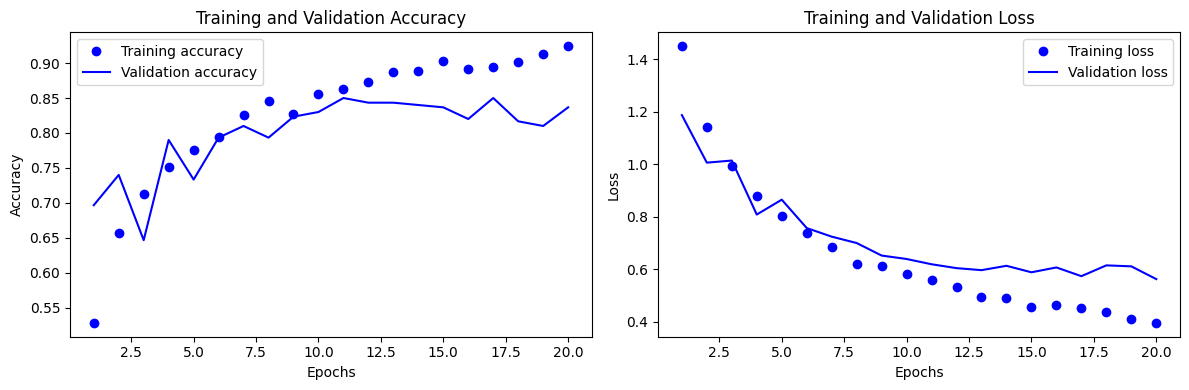

In [13]:
create_and_train_model(train_dataset, test_dataset, model_name='InceptionV3', epochs=20)

19/19 [==============================] - 3s 27ms/step - loss: 0.5625 - accuracy: 0.8367
Test Loss: 0.5624663233757019
Test Accuracy: 0.8366666436195374
1/1 [==============================] - 0s 57ms/step


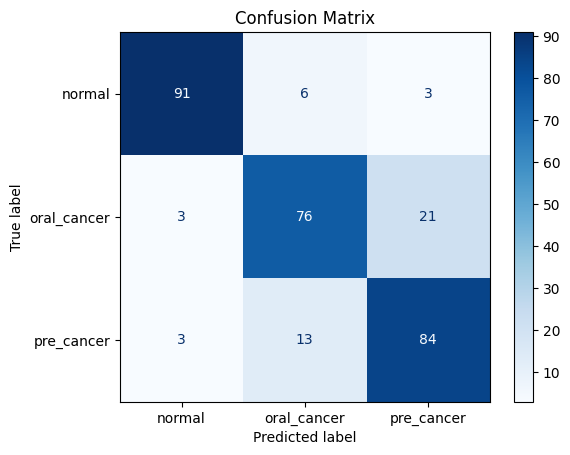

1/1 [==============================] - 0s 44ms/step
Image: normal.455.jpeg - True Class: normal, Predicted Class: normal
Image: normal.348.jpeg - True Class: normal, Predicted Class: normal
Image: normal.361.jpeg - True Class: normal, Predicted Class: oral_cancer
Image: normal.77.jpg - True Class: normal, Predicted Class: oral_cancer
Image: normal.417.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.166.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.50.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.323.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.136.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.494.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.340.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.24.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.162.j

In [14]:
model = tf.keras.models.load_model('inceptionv3.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### DenseNet121

Epoch 1/20
75/75 [==============================] - 15s 102ms/step - loss: 1.3379 - accuracy: 0.5225 - val_loss: 0.9813 - val_accuracy: 0.7000
Epoch 2/20
75/75 [==============================] - 5s 61ms/step - loss: 0.9980 - accuracy: 0.6492 - val_loss: 0.8222 - val_accuracy: 0.7633
Epoch 3/20
75/75 [==============================] - 5s 59ms/step - loss: 0.8399 - accuracy: 0.7192 - val_loss: 0.7455 - val_accuracy: 0.7600
Epoch 4/20
75/75 [==============================] - 5s 59ms/step - loss: 0.7644 - accuracy: 0.7567 - val_loss: 0.6800 - val_accuracy: 0.8200
Epoch 5/20
75/75 [==============================] - 4s 58ms/step - loss: 0.6977 - accuracy: 0.7850 - val_loss: 0.6603 - val_accuracy: 0.8100
Epoch 6/20
75/75 [==============================] - 5s 60ms/step - loss: 0.6603 - accuracy: 0.8033 - val_loss: 0.6108 - val_accuracy: 0.8333
Epoch 7/20
75/75 [==============================] - 5s 60ms/step - loss: 0.5885 - accuracy: 0.8350 - val_loss: 0.5731 - val_accuracy: 0.8433
Epoch 8/20


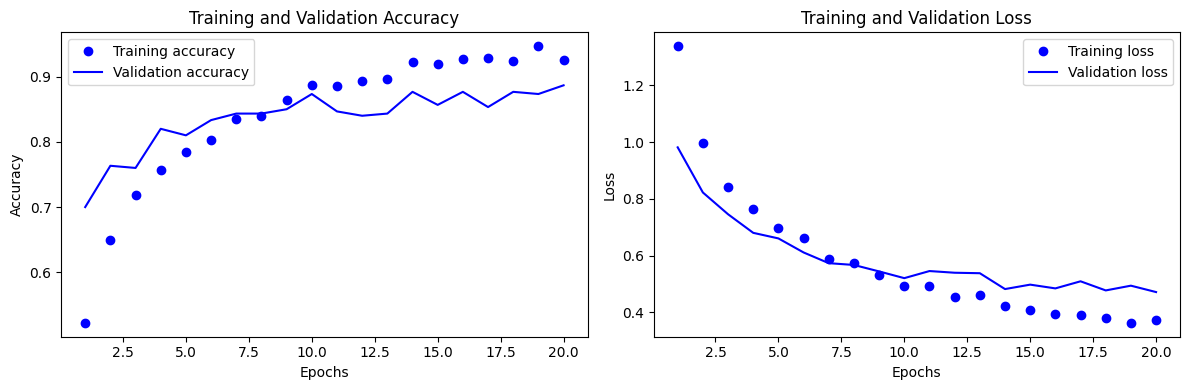

In [15]:
create_and_train_model(train_dataset, test_dataset, model_name='DenseNet121', epochs=20)

19/19 [==============================] - 4s 33ms/step - loss: 0.4712 - accuracy: 0.8867
Test Loss: 0.4712129235267639
Test Accuracy: 0.8866666555404663
1/1 [==============================] - 0s 57ms/step


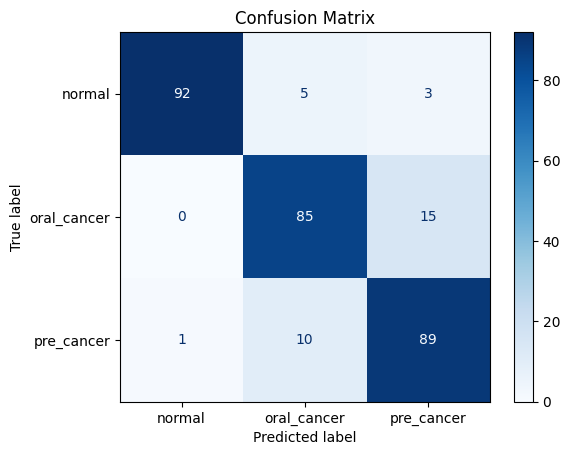

1/1 [==============================] - 0s 52ms/step
Image: normal.8.jpg - True Class: normal, Predicted Class: oral_cancer
Image: normal.322.jpeg - True Class: normal, Predicted Class: normal
Image: normal.67.jpg - True Class: normal, Predicted Class: normal
Image: normal.418.jpeg - True Class: normal, Predicted Class: normal
Image: normal.390.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.476.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.386.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.242.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.465.jpeg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.345.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.494.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.382.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.107.jpg -

In [16]:
model = tf.keras.models.load_model('densenet121.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### MobileNetV2

Epoch 1/20
75/75 [==============================] - 7s 47ms/step - loss: 1.3349 - accuracy: 0.5783 - val_loss: 1.0605 - val_accuracy: 0.7233
Epoch 2/20
75/75 [==============================] - 2s 33ms/step - loss: 1.0282 - accuracy: 0.7167 - val_loss: 0.8886 - val_accuracy: 0.7733
Epoch 3/20
75/75 [==============================] - 2s 32ms/step - loss: 0.8373 - accuracy: 0.7983 - val_loss: 0.7700 - val_accuracy: 0.8200
Epoch 4/20
75/75 [==============================] - 3s 33ms/step - loss: 0.7333 - accuracy: 0.8267 - val_loss: 0.6943 - val_accuracy: 0.8400
Epoch 5/20
75/75 [==============================] - 2s 32ms/step - loss: 0.6785 - accuracy: 0.8467 - val_loss: 0.6373 - val_accuracy: 0.8633
Epoch 6/20
75/75 [==============================] - 2s 32ms/step - loss: 0.6136 - accuracy: 0.8792 - val_loss: 0.6089 - val_accuracy: 0.8467
Epoch 7/20
75/75 [==============================] - 3s 33ms/step - loss: 0.5534 - accuracy: 0.8900 - val_loss: 0.5923 - val_accuracy: 0.8700
Epoch 8/20
75

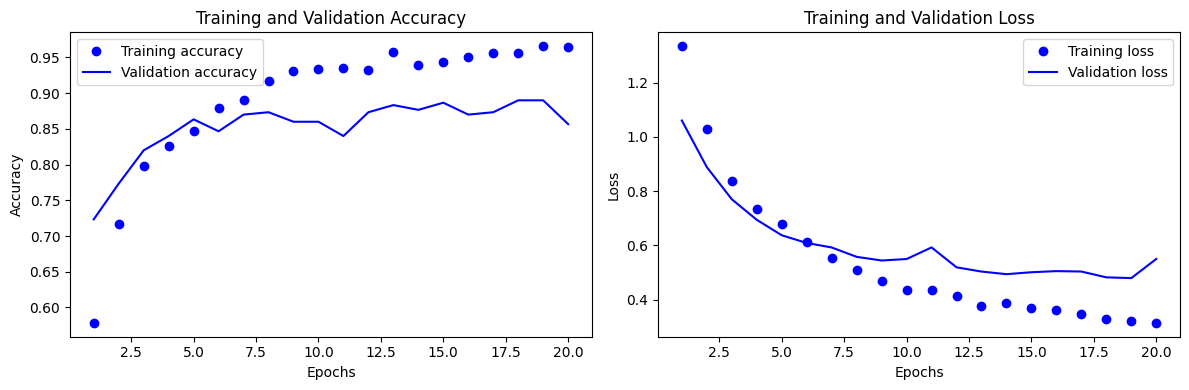

In [17]:
create_and_train_model(train_dataset, test_dataset, model_name='MobileNetV2', epochs=20)

19/19 [==============================] - 2s 20ms/step - loss: 0.4793 - accuracy: 0.8867
Test Loss: 0.47931644320487976
Test Accuracy: 0.8866666555404663
1/1 [==============================] - 0s 46ms/step


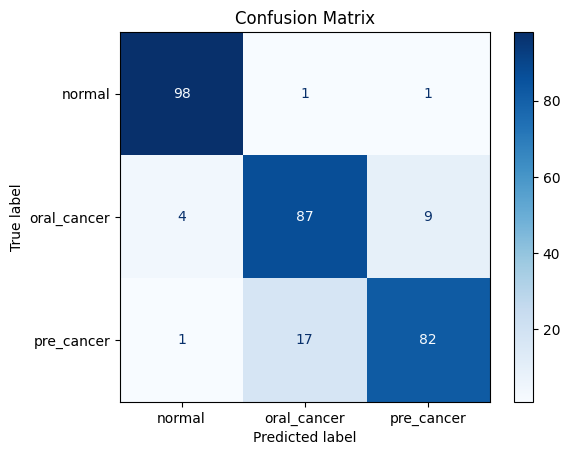

1/1 [==============================] - 0s 42ms/step
Image: normal.89.jpg - True Class: normal, Predicted Class: normal
Image: normal.291.jpeg - True Class: normal, Predicted Class: normal
Image: normal.127.jpg - True Class: normal, Predicted Class: normal
Image: normal.152.jpg - True Class: normal, Predicted Class: normal
Image: normal.352.jpeg - True Class: normal, Predicted Class: oral_cancer
Image: oral_cancer.38.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.355.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.205.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.41.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.419.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.109.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.144.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.202.jpg - Tr

In [18]:
model = tf.keras.models.load_model('mobilenetv2.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### DenseNet169

51877672/51877672 [==============================] - 4s 0us/step
Epoch 1/20
75/75 [==============================] - 17s 110ms/step - loss: 1.2998 - accuracy: 0.5283 - val_loss: 0.9545 - val_accuracy: 0.6800
Epoch 2/20
75/75 [==============================] - 5s 72ms/step - loss: 0.9088 - accuracy: 0.6958 - val_loss: 0.7890 - val_accuracy: 0.7100
Epoch 3/20
75/75 [==============================] - 5s 71ms/step - loss: 0.7696 - accuracy: 0.7633 - val_loss: 0.6499 - val_accuracy: 0.8233
Epoch 4/20
75/75 [==============================] - 6s 74ms/step - loss: 0.6630 - accuracy: 0.7992 - val_loss: 0.5953 - val_accuracy: 0.8467
Epoch 5/20
75/75 [==============================] - 6s 80ms/step - loss: 0.6051 - accuracy: 0.8300 - val_loss: 0.5525 - val_accuracy: 0.8433
Epoch 6/20
75/75 [==============================] - 6s 73ms/step - loss: 0.5481 - accuracy: 0.8683 - val_loss: 0.5325 - val_accuracy: 0.8467
Epoch 7/20
75/75 [==============================] - 4s 47ms/step - loss: 0.4982 - accur

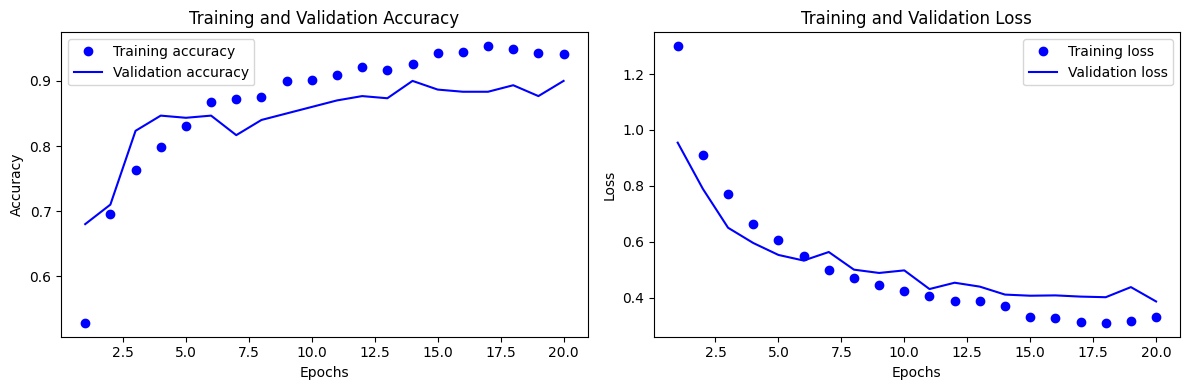

In [19]:
create_and_train_model(train_dataset, test_dataset, model_name='DenseNet169', epochs=20)

19/19 [==============================] - 5s 37ms/step - loss: 0.3860 - accuracy: 0.9000
Test Loss: 0.3859860599040985
Test Accuracy: 0.8999999761581421
1/1 [==============================] - 0s 57ms/step


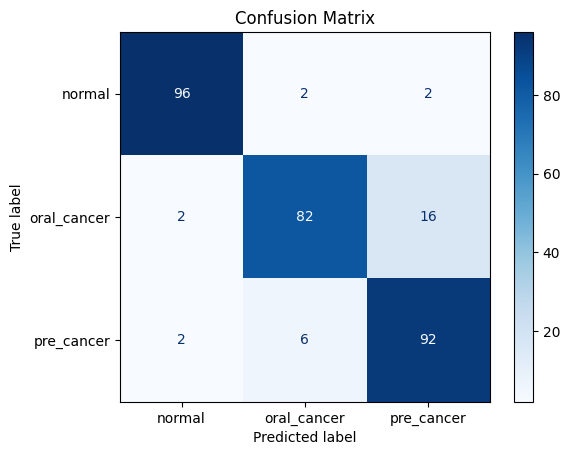

1/1 [==============================] - 0s 55ms/step
Image: normal.104.jpg - True Class: normal, Predicted Class: normal
Image: normal.473.jpeg - True Class: normal, Predicted Class: normal
Image: normal.418.jpeg - True Class: normal, Predicted Class: normal
Image: normal.150.jpg - True Class: normal, Predicted Class: oral_cancer
Image: normal.480.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.45.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.88.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.93.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.169.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.469.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.378.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.173.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.109.jpg - T

In [20]:
model = tf.keras.models.load_model('densenet169.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

### DenseNet201

74836368/74836368 [==============================] - 5s 0us/step
Epoch 1/20
75/75 [==============================] - 22s 135ms/step - loss: 1.2682 - accuracy: 0.5200 - val_loss: 0.9103 - val_accuracy: 0.7333
Epoch 2/20
75/75 [==============================] - 7s 87ms/step - loss: 0.8978 - accuracy: 0.6808 - val_loss: 0.6948 - val_accuracy: 0.8200
Epoch 3/20
75/75 [==============================] - 7s 88ms/step - loss: 0.7313 - accuracy: 0.7658 - val_loss: 0.6863 - val_accuracy: 0.7500
Epoch 4/20
75/75 [==============================] - 7s 87ms/step - loss: 0.6319 - accuracy: 0.8058 - val_loss: 0.5591 - val_accuracy: 0.8467
Epoch 5/20
75/75 [==============================] - 7s 95ms/step - loss: 0.5764 - accuracy: 0.8367 - val_loss: 0.5275 - val_accuracy: 0.8533
Epoch 6/20
75/75 [==============================] - 7s 86ms/step - loss: 0.5142 - accuracy: 0.8683 - val_loss: 0.4723 - val_accuracy: 0.8700
Epoch 7/20
75/75 [==============================] - 4s 55ms/step - loss: 0.4722 - accur

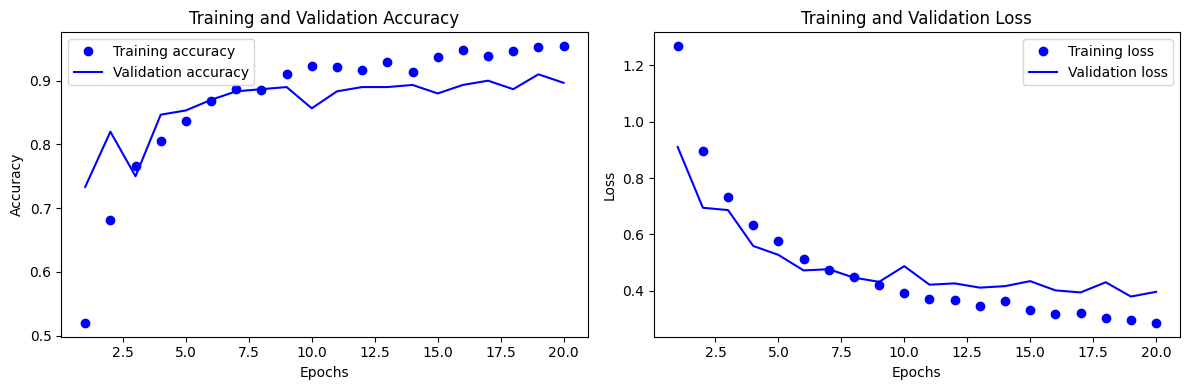

In [21]:
create_and_train_model(train_dataset, test_dataset, model_name='DenseNet201', epochs=20)

19/19 [==============================] - 6s 42ms/step - loss: 0.3796 - accuracy: 0.9100
Test Loss: 0.3796122670173645
Test Accuracy: 0.9100000262260437
1/1 [==============================] - 0s 57ms/step


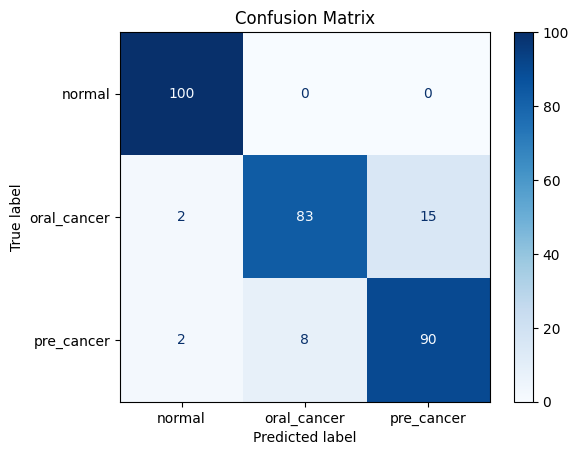

1/1 [==============================] - 0s 55ms/step
Image: normal.358.jpeg - True Class: normal, Predicted Class: normal
Image: normal.39.jpg - True Class: normal, Predicted Class: normal
Image: normal.363.jpeg - True Class: normal, Predicted Class: normal
Image: normal.390.jpeg - True Class: normal, Predicted Class: normal
Image: normal.103.jpg - True Class: normal, Predicted Class: normal
Image: oral_cancer.407.png - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.386.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.494.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.50.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.271.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.265.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.190.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.138.jpg - True

In [22]:
model = tf.keras.models.load_model('densenet201.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=False)

## Best Model

In [27]:
# split dataset into train, test and val splits

original_dir = pathlib.Path("new_aug_dataset")
if os.path.exists('oral_cancer_train_test_val_split'):
    shutil.rmtree('oral_cancer_train_test_val_split')
new_base_dir = pathlib.Path("oral_cancer_train_test_val_split")

# classes
categories = ["normal", "pre_cancer", "oral_cancer"]

train_files = {}
val_files = {}
test_files = {}

# split
for category in categories:
    all_files = get_file_names(category)

    # train and temp (for validation and test)
    train, temp = train_test_split(all_files, test_size=0.3, random_state=42)
    
    # temp -> val and test
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    train_files[category] = train
    val_files[category] = val
    test_files[category] = test

make_subset("train", train_files)
make_subset("val", val_files)
make_subset("test", test_files)

print('Created training, validation, and testing subsets.')

Created training, validation, and testing subsets.


### Load data

In [29]:
# load datasets

batch_size = 16  # found to be best after hyperparamter tuning

# train
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'oral_cancer_train_test_val_split/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=batch_size
)

class_names = train_dataset.class_names

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# test
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'oral_cancer_train_test_val_split/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=batch_size
)

test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# val
val_dataset = tf.keras.utils.image_dataset_from_directory(
    'oral_cancer_train_test_val_split/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=batch_size
)

val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 1050 files belonging to 3 classes.
Found 225 files belonging to 3 classes.
Found 225 files belonging to 3 classes.


## DenseNet201

Epoch 1/100
66/66 [==============================] - 20s 155ms/step - loss: 1.3252 - accuracy: 0.4819 - val_loss: 1.0141 - val_accuracy: 0.6444
Epoch 2/100
66/66 [==============================] - 6s 86ms/step - loss: 0.9500 - accuracy: 0.6524 - val_loss: 0.8403 - val_accuracy: 0.7244
Epoch 3/100
66/66 [==============================] - 6s 85ms/step - loss: 0.7952 - accuracy: 0.7448 - val_loss: 0.7303 - val_accuracy: 0.7733
Epoch 4/100
66/66 [==============================] - 6s 86ms/step - loss: 0.6832 - accuracy: 0.7914 - val_loss: 0.6653 - val_accuracy: 0.7644
Epoch 5/100
66/66 [==============================] - 6s 86ms/step - loss: 0.6112 - accuracy: 0.8143 - val_loss: 0.6010 - val_accuracy: 0.8133
Epoch 6/100
66/66 [==============================] - 6s 87ms/step - loss: 0.5522 - accuracy: 0.8590 - val_loss: 0.5892 - val_accuracy: 0.7956
Epoch 7/100
66/66 [==============================] - 6s 87ms/step - loss: 0.5107 - accuracy: 0.8619 - val_loss: 0.5408 - val_accuracy: 0.8356
Epoc

66/66 [==============================] - 3s 51ms/step - loss: 0.2141 - accuracy: 0.9857 - val_loss: 0.4094 - val_accuracy: 0.8933
Epoch 59/100
66/66 [==============================] - 3s 51ms/step - loss: 0.2315 - accuracy: 0.9762 - val_loss: 0.4191 - val_accuracy: 0.8978
Epoch 60/100
66/66 [==============================] - 3s 51ms/step - loss: 0.2152 - accuracy: 0.9810 - val_loss: 0.4023 - val_accuracy: 0.8978
Epoch 61/100
66/66 [==============================] - 3s 51ms/step - loss: 0.2147 - accuracy: 0.9781 - val_loss: 0.3975 - val_accuracy: 0.8978
Epoch 62/100
66/66 [==============================] - 3s 50ms/step - loss: 0.2264 - accuracy: 0.9762 - val_loss: 0.3822 - val_accuracy: 0.9111
Epoch 63/100
66/66 [==============================] - 3s 51ms/step - loss: 0.2168 - accuracy: 0.9800 - val_loss: 0.3825 - val_accuracy: 0.9200
Epoch 64/100
66/66 [==============================] - 3s 50ms/step - loss: 0.2182 - accuracy: 0.9790 - val_loss: 0.3978 - val_accuracy: 0.8889
Epoch 65/100

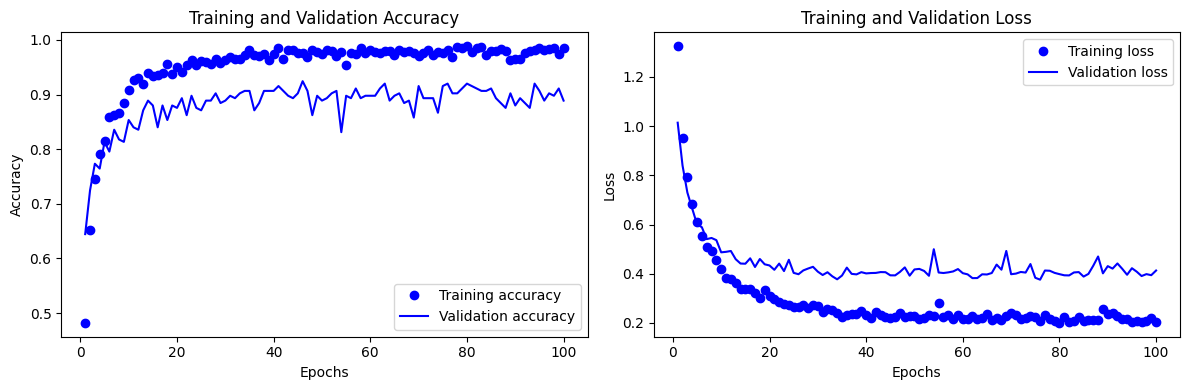

In [30]:
create_and_train_model(train_dataset, val_dataset, model_name='DenseNet201', epochs=100)

15/15 [==============================] - 8s 44ms/step - loss: 0.3391 - accuracy: 0.9111
Test Loss: 0.3391498923301697
Test Accuracy: 0.9111111164093018
1/1 [==============================] - 0s 57ms/step


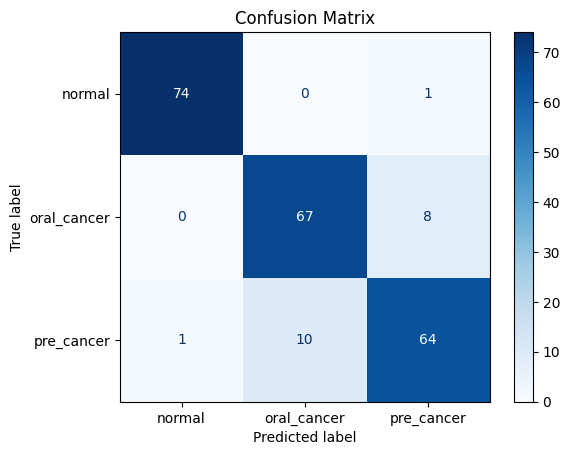

1/1 [==============================] - 0s 56ms/step
Image: normal.220.jpg - True Class: normal, Predicted Class: normal
Image: normal.379.jpeg - True Class: normal, Predicted Class: normal
Image: normal.366.jpeg - True Class: normal, Predicted Class: normal
Image: normal.500.jpeg - True Class: normal, Predicted Class: normal
Image: normal.150.jpg - True Class: normal, Predicted Class: normal
Image: oral_cancer.91.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.169.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.284.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.348.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.80.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.199.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.95.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.378.jpg - True 

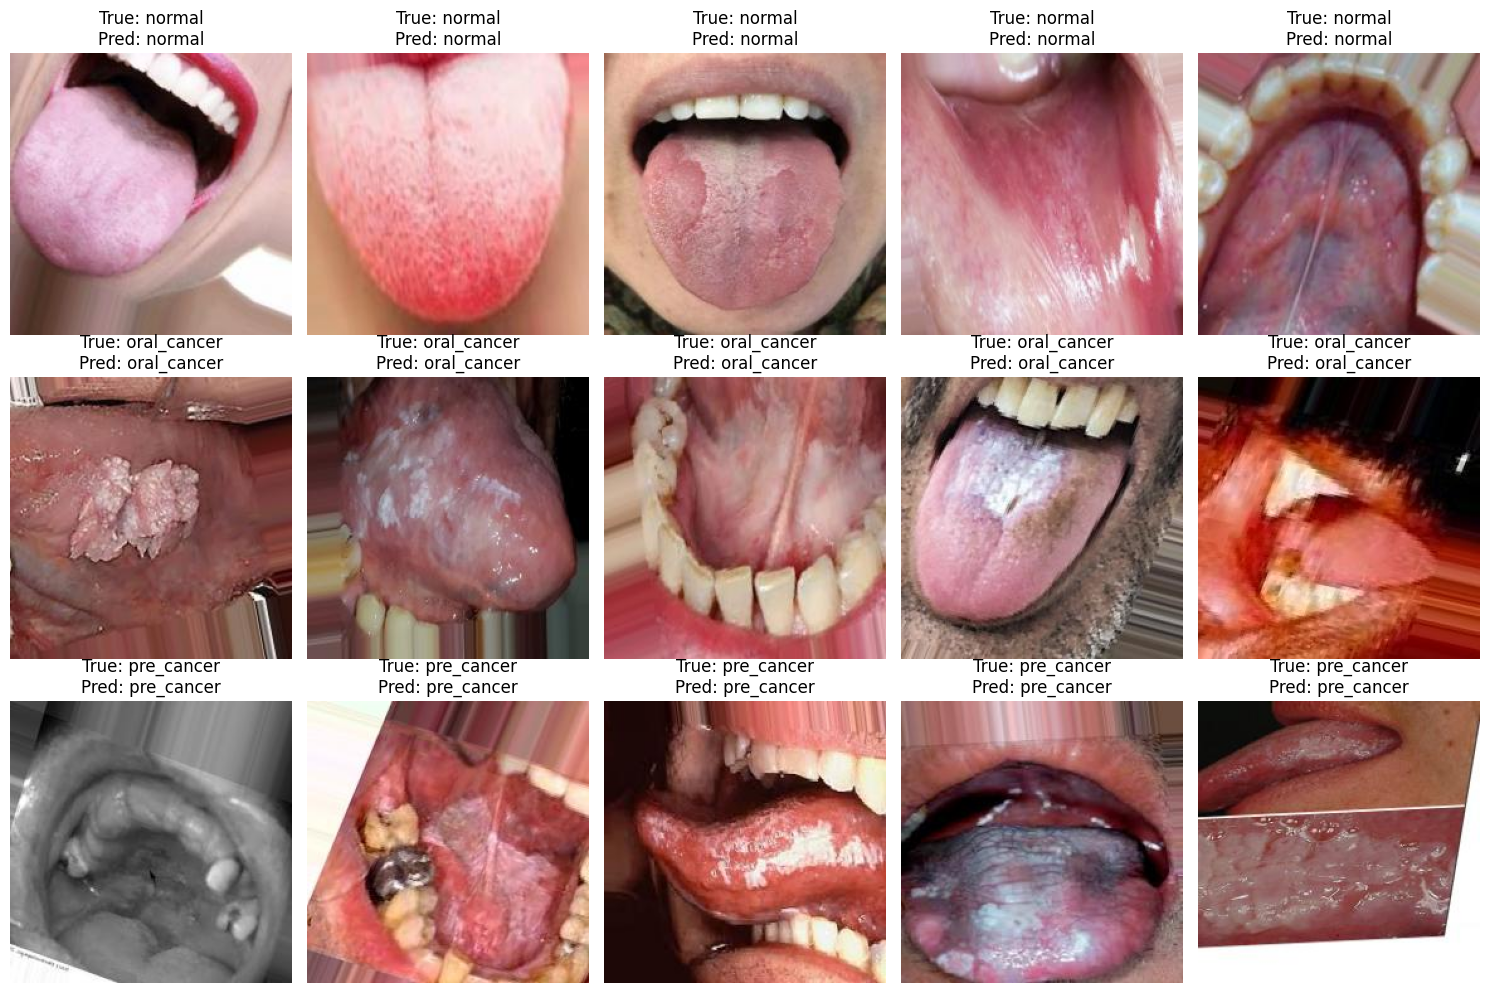

In [34]:
model = tf.keras.models.load_model('densenet201.keras')

evaluate_and_display_model(model, test_dataset, class_names, display_image=True)

In [36]:
# save best model

os.mkdir('best_model')
model.save('best_model/densenet201_model.keras')
print('Saved best model.')

Saved best model.


## Convert to tflite

In [39]:
# convert the model to tflite for app

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save tflite model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# move to assets folder in flutter_app
shutil.move('model.tflite', os.path.join('flutter_app/assets', 'model.tflite'))

print('Saved tflite model.')

INFO:tensorflow:Assets written to: /tmp/tmpxnwzni59/assets


INFO:tensorflow:Assets written to: /tmp/tmpxnwzni59/assets
2024-10-07 09:27:27.694727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-07 09:27:27.694775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-07 09:27:27.695912: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxnwzni59
2024-10-07 09:27:27.840204: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-07 09:27:27.840237: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxnwzni59
2024-10-07 09:27:28.125117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-07 09:27:28.267073: I tensorflow/cc/saved_model/loader.cc:235] Restoring SavedModel bundle.
2024-10-07 09:27:31.264964: I tensorflow/cc/saved_model/loader.cc:219] Running initializatio

Saved tflite model.
